In [0]:
import pandas as pd 
import numpy as np 
from functools import reduce
from os import path
import json
from collections import Counter
from itertools import chain 
from pathlib import Path
import tensorflow as tf
import sys
import pickle
import os

import matplotlib.pyplot as plt 
%matplotlib inline
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']

In [18]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
BASE_DIR = '/content/drive/My Drive/kaikeba_nlp2/'
if BASE_DIR not in sys.path:
  sys.path.append(BASE_DIR)

In [0]:
import sys
import tensorflow as tf
from pathlib import Path
import argparse
from projects.P01_QA_summarization_inference.src.utils.train_eval_test import train
from projects.P01_QA_summarization_inference.src.utils.train_eval_test import test_save
from projects.P01_QA_summarization_inference.config.readconfig import ReadConfig

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
def run(epoch=20, steps=1300, test_num=20000, mode='train', bz=64, lr=0.0001): 
  NUM_SAMPLES = 82867
  parser = argparse.ArgumentParser()

  # model params
  parser.add_argument("--max_enc_len", default=200, help="Encoder input max sequence length", type=int)
  parser.add_argument("--max_dec_len", default=40, help="Decoder input max sequence length", type=int)
  parser.add_argument("--max_dec_steps", default=100,
                      help="maximum number of words of the predicted abstract", type=int)
  parser.add_argument("--min_dec_steps", default=30,
                      help="Minimum number of words of the predicted abstract", type=int)
  parser.add_argument("--beam_size", default=3,
                      help="beam size for beam search decoding (must be equal to batch size in decode mode)",
                      type=int)
  parser.add_argument("--vocab_size", default=30000, help="Vocabulary size", type=int)
  parser.add_argument("--embed_size", default=256, help="Words embeddings dimension", type=int)
  parser.add_argument("--enc_units", default=256, help="Encoder GRU cell units number", type=int)
  parser.add_argument("--dec_units", default=256, help="Decoder GRU cell units number", type=int)
  parser.add_argument("--attn_units", default=256,
                      help="[context vector, decoder state, decoder input] feedforward result dimension - "
                            "this result is used to compute the attention weights", type=int)
  parser.add_argument("--learning_rate", default=lr, help="Learning rate", type=float)
  parser.add_argument("--adagrad_init_acc", default=0.1,
                      help="Adagrad optimizer initial accumulator value. Please refer to the Adagrad optimizer "
                            "API documentation on tensorflow site for more details.", type=float)
  parser.add_argument("--max_grad_norm", default=0.8, help="Gradient norm above which gradients must be clipped",
                      type=float)
  parser.add_argument('--cov_loss_wt', default=0.5, help='Weight of coverage loss (lambda in the paper).'
                                                          ' If zero, then no incentive to minimize coverage loss.',
                      type=float)

  # path
  loc_path = ReadConfig()
  vocab_path = loc_path.get_path('vocab')
  w2v_embedding_path = loc_path.get_path('w2v_embedding')
  ft_embedding_path = loc_path.get_path('ft_embedding')
  tencent_embedding_path = loc_path.get_path('tencent_embedding')
  train_set_x_path = loc_path.get_path('train_set_x')
  train_set_y_path = loc_path.get_path('train_set_y')
  test_set_x_path = loc_path.get_path('test_set_x')
  test_raw_path = loc_path.get_path('test_raw')
  seq2seq_model_dir = loc_path.get_path('seq2seq_model')
  pgn_model_dir = loc_path.get_path('pgn_model')
  test_output_dir = loc_path.get_path('test_output')

  parser.add_argument("--seq2seq_model_dir", default=seq2seq_model_dir, help="Model folder")
  parser.add_argument("--pgn_model_dir", default=pgn_model_dir, help="Model folder")
  parser.add_argument("--model_path", help="Path to a specific model", default="", type=str)
  parser.add_argument("--train_seg_x_dir", default=train_set_x_path, help="train_seg_x_dir")
  parser.add_argument("--train_seg_y_dir", default=train_set_y_path, help="train_seg_y_dir")
  parser.add_argument("--test_seg_x_dir", default=test_set_x_path, help="test_seg_x_dir")
  parser.add_argument("--log_file", help="File in which to redirect console outputs", default="", type=str)
  parser.add_argument("--test_x_dir", default=test_raw_path, help="test_x_dir")
  parser.add_argument("--test_save_dir", default=test_output_dir, help="test_save_dir")
  parser.add_argument("--vocab_path", default=vocab_path, help="Vocab path")
  parser.add_argument("--word2vec_output", default=w2v_embedding_path, help="word to embedding path")

  # others
  parser.add_argument("--batch_size", default=bz, help="batch size", type=int)
  parser.add_argument("--epochs", default=epoch, help="train epochs", type=int)
  parser.add_argument("--steps_per_epoch", default=steps, help="max_train_steps", type=int)
  parser.add_argument("--checkpoints_save_epochs", default=1, help="Save checkpoints every N epochs", type=int)
  parser.add_argument("--loss_print_step", default=100, help="Print batch loss every N steps", type=int)
  parser.add_argument("--max_steps", default=10000, help="Max number of iterations", type=int)
  parser.add_argument("--num_to_test", default=test_num, help="Number of examples to test", type=int)
  parser.add_argument("--max_num_to_eval", default=2, help="max_num_to_eval", type=int)

  # mode
  parser.add_argument("--mode", default=mode, help="training, eval or test options")
  parser.add_argument("--model", default='SequenceToSequence', help="which model to be selected")
  parser.add_argument("--greedy_decode", default=True, help="greedy_decoder")

  args = parser.parse_args(args=[])
  params = vars(args)

  gpu = tf.config.experimental.list_physical_devices(device_type='GPU')
  if gpu:
      tf.config.experimental.set_visible_devices(devices=gpu[0], device_type='GPU')
  print(gpu)

  if params["mode"] == "train":
    # params["steps_per_epoch"] = NUM_SAMPLES // params["batch_size"]
    train(params)
  elif params["mode"] == "test":
    test_save(params)

In [6]:
run(epoch=10, steps=1300, bz=64, lr=0.0001)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Creating the model ...
max_size of vocab was specified as 30000; we now have 30000 words. Stopping reading.
Finished constructing vocabulary of 30000 total words. Last word added: 红接
Creating the checkpoint manager ...
Restored from /content/drive/My Drive/kaikeba_nlp2/projects/P01_QA_summarization_inference/models/seq2seq/checkpoint/ckpt-16
Start the training ...
max_size of vocab was specified as 30000; we now have 30000 words. Stopping reading.
Finished constructing vocabulary of 30000 total words. Last word added: 红接
True vocab is <projects.P01_QA_summarization_inference.src.utils.batcher.Vocab object at 0x7fa1d04094e0>
Creating the batch set ...
Epoch 1 Batch 100 Loss 4.6116
Epoch 1 Batch 200 Loss 4.3809
Epoch 1 Batch 300 Loss 4.6109
Epoch 1 Batch 400 Loss 4.7739
Epoch 1 Batch 500 Loss 4.4413
Epoch 1 Batch 600 Loss 4.6688
Epoch 1 Batch 700 Loss 4.7865
Epoch 1 Batch 800 Loss 4.6472
Epoch 1 Batch 900 Loss 4.7138
Epoc

In [19]:
run(test_num=128, mode='test', bz=64)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Building the model ...
max_size of vocab was specified as 30000; we now have 30000 words. Stopping reading.
Finished constructing vocabulary of 30000 total words. Last word added: 红接


  0%|          | 0/2 [00:00<?, ?it/s]

Creating the checkpoint manager ...
Restored model
Predicting the results ...
max_size of vocab was specified as 30000; we now have 30000 words. Stopping reading.
Finished constructing vocabulary of 30000 total words. Last word added: 红接
True vocab is <projects.P01_QA_summarization_inference.src.utils.batcher.Vocab object at 0x7f2f65191e80>
Creating the batch set ...


100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


In [20]:
loc_path = ReadConfig()
test_output_dir = loc_path.get_path('test_output')
files = os.listdir(test_output_dir)
files

['.gitkeep',
 '.ipynb_checkpoints',
 '2020_05_24_02_53_30_batch_size_64_epochs_20_max_length_inp_40_embedding_dim_256_.csv']

In [21]:
out_put_path = os.path.join(test_output_dir, files[2])
out_df = pd.read_csv(out_put_path, encoding='utf-8')
out_df.head(5)

,QID,Prediction
0,Q1,更换
1,Q2,可以了
2,Q3,可以了
3,Q4,更换
4,Q5,更换


In [0]:
w2v_embedding_path = loc_path.get_path('w2v_embedding')
with open(w2v_embedding_path, 'rb') as f:
  w2v = pickle.load(f)

In [0]:
vals = np.array(list(w2v.values()))
vals = vals.flatten()
vals.sort()
vals[:10]

array([-1.3401859, -1.3304938, -1.330378 , -1.3243086, -1.3035579,
       -1.2973418, -1.2809175, -1.2687092, -1.2654564, -1.2638444],
      dtype=float32)

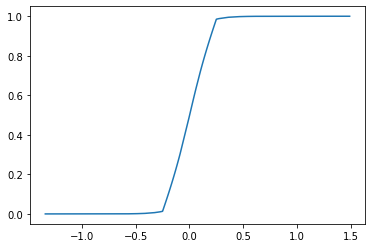

In [0]:
plt.plot(vals, np.arange(len(vals))/len(vals))

In [0]:
train_set_x_path = loc_path.get_path('train_set_x')
train_set_y_path = loc_path.get_path('train_set_y')
test_set_x_path = loc_path.get_path('test_set_x')

In [0]:
def get_lines_len(file_path):
  res = []
  with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
      line=line.strip().split()
      res.append(len(line))
  return np.array(res)

In [0]:
train_x_len = get_lines_len(train_set_x_path)
train_y_len = get_lines_len(train_set_y_path)
test_x_len = get_lines_len(test_set_x_path)

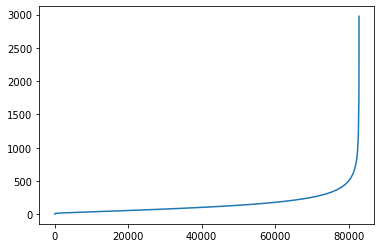

In [0]:
plt.plot(np.arange(train_x_len.shape[0]), sorted(train_x_len))

In [0]:
counter = Counter(train_x_len)

In [0]:
len_cnt = counter.most_common()
len, cnt = zip(*len_cnt)
percent = cnt / np.sum(cnt) *100
top = 50

<BarContainer object of 1233 artists>

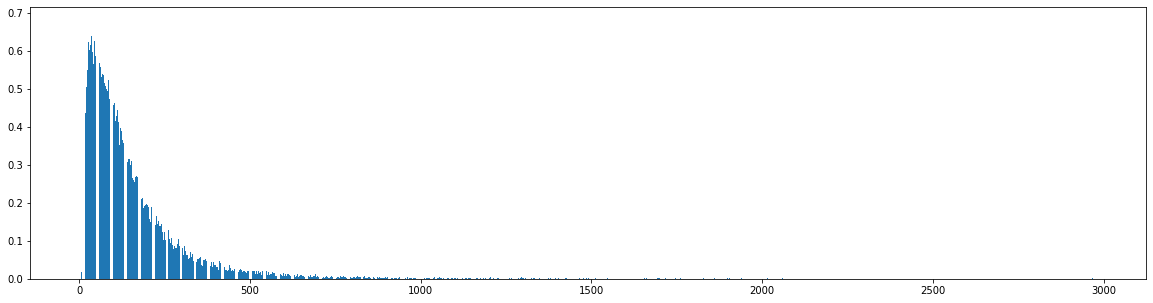

In [0]:
plt.figure(figsize=(20, 5))
plt.bar(len, percent)

(array([73609., 81130., 82366., 82679., 82792., 82841., 82857., 82862.,
        82863., 82867.]),
 array([   5.,  302.,  599.,  896., 1193., 1490., 1787., 2084., 2381.,
        2678., 2975.]),
 <a list of 1 Patch objects>)

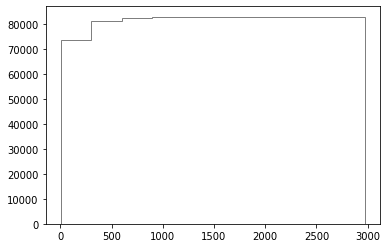

In [0]:
plt.hist(train_x_len, cumulative=True, histtype='step', alpha=0.5, color='k')

(array([80352., 82752., 82854., 82863., 82864., 82864., 82866., 82866.,
        82866., 82867.]),
 array([  1. ,  47.8,  94.6, 141.4, 188.2, 235. , 281.8, 328.6, 375.4,
        422.2, 469. ]),
 <a list of 1 Patch objects>)

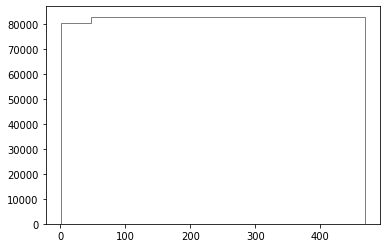

In [0]:
plt.hist(train_y_len, cumulative=True, histtype='step', alpha=0.5, color='k')

(array([18575., 19758., 19941., 19979., 19988., 19993., 19996., 19998.,
        19998., 20000.]),
 array([   8. ,  379.7,  751.4, 1123.1, 1494.8, 1866.5, 2238.2, 2609.9,
        2981.6, 3353.3, 3725. ]),
 <a list of 1 Patch objects>)

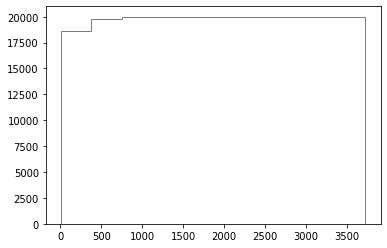

In [0]:
plt.hist(test_x_len, cumulative=True, histtype='step', alpha=0.5, color='k')